In [3]:
from sklearn.metrics import roc_auc_score, roc_curve
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.metrics import recall_score
from sklearn.metrics import auc as auc_score
from sklearn.metrics import plot_roc_curve
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import json
import os
import glob
from natsort import natsorted
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process.kernels import RBF
from sklearn.neural_network import MLPClassifier
import PIL
from scipy import stats
import seaborn as sns

In [4]:
sns.set()

In [5]:
np.prod([2,3,4])

24

In [6]:
def gen_mean(P, r):
    J = len(P)
    return (np.sum(np.power(P, r))/J)**(1/r)

def LSE(P, r):
    J = len(P)
    inner = np.sum(np.exp(r*P))
    return (np.log(inner/J))/r

def noise_or(P):
    return 1 - np.prod(1 - P)

def isr(P):
    left = np.sum(P/(1-P))
    right = 1 + left
    return left / right

In [60]:
model_id = '3laukacx'
test_data_files = glob.glob(f'/home/colin/results_cov/*{model_id}*.json')
test_data = {}
for tdf in test_data_files[0:]:
    with open(tdf) as fp:
        td = json.load(fp)
    for key, value in td.items():
        if key not in test_data:
            test_data[key] = value
            predictions = value['predictions']
            predictions = [pred[1] for pred in predictions if np.argmax(pred) != 2]
            test_data[key]['predictions'] = predictions
        else:
            test_data[key]['predictions'] += np.array(value['predictions'])[:,-1].tolist()
    break

In [34]:
np.array(value['predictions'])[:,-1]

array([0.678397  , 0.54222393, 0.19815677, 0.70066923, 0.61323911,
       0.58603996, 0.46365559, 0.61833727, 0.39787531])

In [56]:
pos_preds_by_cell_type = [[] for _ in cell_types_li]
neg_preds_by_cell_type = [[] for _ in cell_types_li]
for value in test_data.values():
    label = value['label']
    for pred, file in zip(value['predictions'], value['files']):
        cell_type = cell_type_data[file]
        if label == 1:
            pos_preds_by_cell_type[cell_type].append(pred)
        else:
            neg_preds_by_cell_type[cell_type].append(pred)

In [57]:
cell_types_li = ['basophil',
 'eosinophil',
 'erythroblast',
 'garbage',
 'ig',
 'lymphocyte',
 'monocyte',
 'neutrophil',
 'platelet']

In [58]:
pos_preds_by_cell_type = [[] for _ in cell_types_li]
neg_preds_by_cell_type = [[] for _ in cell_types_li]
for value in test_data.values():
    label = value['label']
    for pred, file in zip(value['predictions'], value['files']):
        cell_type = cell_type_data[file]
        if label == 1:
            pos_preds_by_cell_type[cell_type].append(pred)
        else:
            neg_preds_by_cell_type[cell_type].append(pred)

Text(0, 0.5, 'Confidence')

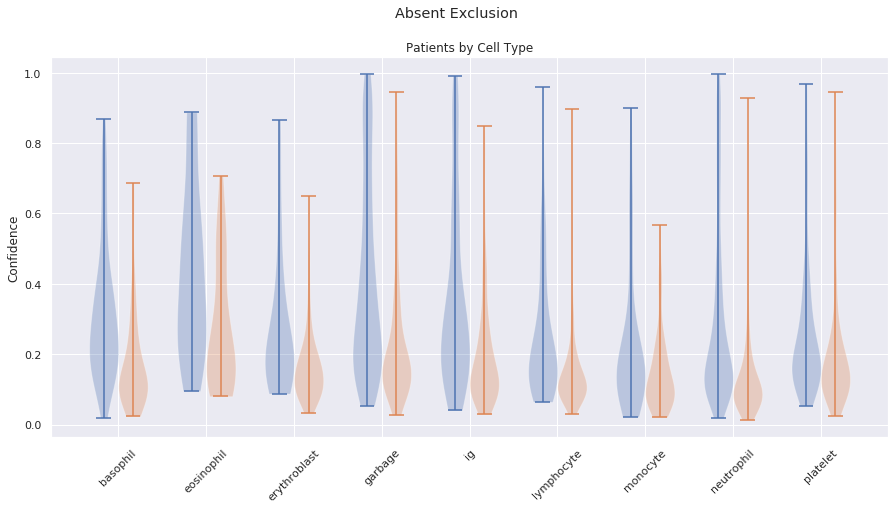

In [61]:
plt.figure(figsize=(15, 7))
plt.suptitle("Absent Exclusion")
plt.title("Patients by Cell Type")
plt.violinplot(pos_preds_by_cell_type,positions=np.arange(1, 28, 3), widths=1)
plt.violinplot(neg_preds_by_cell_type,positions=np.arange(2, 29, 3), widths=1)
plt.xticks(np.arange(1, 28, 3)+0.5 , cell_types_li, rotation=45)
plt.ylabel("Confidence")

In [12]:
positive_preds = [values['predictions'] for values in test_data.values() if values['label'] == 1]
negative_preds = [values['predictions'] for values in test_data.values() if values['label'] == 0]

In [11]:
with open('/home/colin/wbc_class_1dr34rc5_v3.json') as fp:
    cell_type_data = json.load(fp)
    cell_type_data = {os.path.basename(key): value for key, value in cell_type_data.items()}

Text(0, 0.5, 'Confidence')

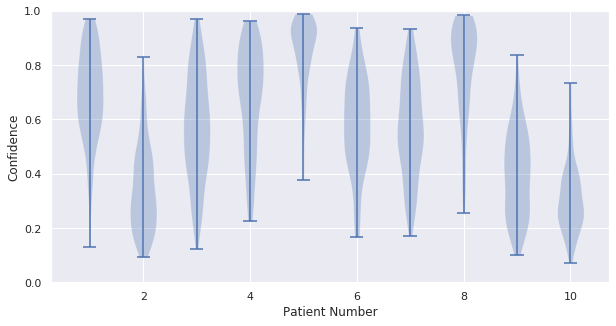

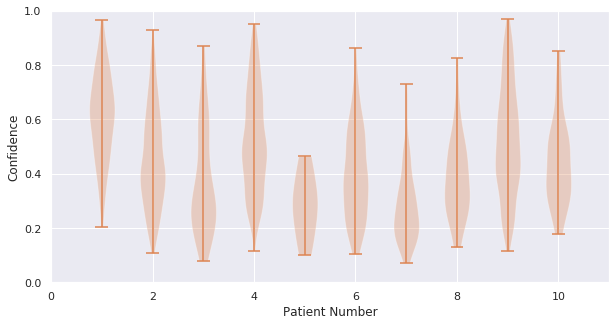

In [22]:
plt.figure(figsize=(10,5))
plt.violinplot(positive_preds[0:10])
plt.xlabel("Patient Number")
plt.ylabel("Confidence")
plt.ylim(0, 1)
plt.figure(figsize=(10,5))
plt.violinplot([0], [-1])
plt.violinplot(negative_preds[0:10])
plt.xlabel("Patient Number")
plt.xlim(0, 11)
plt.ylim(0, 1)
plt.ylabel("Confidence")

In [44]:
for i in test_data.items():
    break

In [48]:
labels = [values['label'] for values in test_data.values()]
predictions = [np.array(values['predictions']) for values in test_data.values()]
med_predictions = [np.median(v) for v in predictions]
lse_r1_preds = [LSE(p, 1) for p in predictions]
lse_r2_5_preds = [LSE(p, 2.5) for p in predictions]
lse_r5_preds = [LSE(p, 5) for p in predictions]

gm_r1 = [gen_mean(p, 1) for p in predictions]
gm_r2_5 = [gen_mean(p, 2.5) for p in predictions]
gm_r5 = [gen_mean(p, 5) for p in predictions]

noise = [noise_or(p) for p in predictions]
isr_strat = [isr(p) for p in predictions]

names = ['median', 'lse_r1', 'lse_r2.5', 'lse_r5', 'gm_r1', 'gm_r2.5', 'gm_5', 'noisy_or', 'ISR']
pred_stats = [med_predictions,
             lse_r1_preds,
             lse_r2_5_preds,
             lse_r5_preds,
             gm_r1,
             gm_r2_5,
             gm_r5,
             noise,
             isr_strat]
for name, preds in zip(names, pred_stats):
    print(name, roc_auc_score(labels, preds))

median 0.8253968253968254
lse_r1 0.8158730158730159
lse_r2.5 0.8126984126984127
lse_r5 0.8063492063492063
gm_r1 0.819047619047619
gm_r2.5 0.8095238095238094
gm_5 0.8063492063492063
noisy_or 0.5333333333333333
ISR 0.7746031746031745
